# Understanding IQMs generated by MRIQC

The `mriqc-learn` package comes with some example data for users, derived from the MRIQC paper.
First, we will be using a dataset containing IQMs generated on the open-access ABIDE I dataset which contains manual assessments by human raters.
Let's explore the dataset:

In [1]:
# 1. mriqc-learn comes with a convenience data loader, you'll need to first import it.
from mriqc_learn.datasets import load_dataset

# 2. Once imported, let's pull up some data
(train_x, train_y), _ = load_dataset(split_strategy="none")

With the argument `split_strategy="none"` we are indicating that we want to obtain the full dataset, without partitioning it in any ways.
That means variable `train_x` will contain *features* (in other words, the actual IQMs) and `train_y` contains manual assessments, for 1101 T1-weighted MRI images of ABIDE I.
Both data tables `train_x` and `train_y` have the structure of Pandas DataFrames.

In order to investigate those "site-effects", let's add a column to `train_x` with site information:

In [2]:
train_x["site"] = train_y.site

These sites correspond to the following acquisition parameters:

<img src="https://journals.plos.org/plosone/article/figure/image?size=large&download=&id=10.1371/journal.pone.0184661.t001" />

## A first look on the dataset
Lets now have a first quick look over the data:

In [3]:
train_x

,cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,icvs_gm,...,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max,site
0,0.383747,3.259968,0.609668,181.619858,3.944888,3.959924,4.039157,3.835584,0.199774,0.449138,...,1000.013428,189965.0,908.938904,1079.413428,51.778980,0.225944,0.525072,0.540801,0.540213,PITT
1,0.574080,2.279440,0.606361,172.500031,3.992397,3.877495,4.173095,3.926602,0.203301,0.429628,...,1000.033569,187992.0,901.788293,1120.833569,67.136932,0.223374,0.521399,0.560238,0.571425,PITT
2,0.314944,3.998569,0.577123,273.688171,4.016382,4.066009,4.092888,3.890248,0.201591,0.446495,...,1000.015198,188213.0,913.847803,1067.003662,46.623932,0.233414,0.531020,0.556496,0.612655,PITT
3,0.418505,3.050534,0.571343,237.531143,3.601741,3.629409,3.627568,3.548246,0.190612,0.468255,...,1000.005981,146722.0,872.409717,1083.139264,63.131420,0.227282,0.528115,0.526254,0.600312,PITT
4,0.286560,4.214082,0.550083,427.042389,3.808350,3.839143,3.841085,3.744823,0.162421,0.505201,...,1000.004150,162584.0,900.433481,1069.912750,50.874363,0.195150,0.543591,0.531606,0.603308,PITT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,0.428731,3.030323,0.789654,2519.999512,3.176760,3.166740,3.359990,3.003550,0.169851,0.424819,...,1000.034668,241117.0,902.529590,1088.244409,56.683868,0.162535,0.476992,0.536843,0.537140,SBL
1097,0.610845,2.155928,0.800116,1769.720093,3.209497,3.164760,3.381280,3.082450,0.170732,0.405536,...,1000.039429,251136.0,903.951080,1093.323273,57.789230,0.193376,0.465232,0.545695,0.564010,SBL
1098,0.461773,2.794299,0.789859,2248.858398,3.149920,3.112220,3.326700,3.010840,0.165501,0.441190,...,1000.036438,209298.0,891.934216,1093.973322,61.108639,0.198508,0.497137,0.523571,0.564865,SBL
1099,0.457718,2.862913,0.706924,114.865364,3.486750,3.421200,3.881950,3.157100,0.209701,0.381839,...,999.990356,234957.0,904.907922,1101.429980,60.045422,0.235618,0.477310,0.563352,0.534626,MAX_MUN


This first look is not very informative - there's no way we can pick any of the structure in our dataset.
Let's make use of one plotting utility of `mriqc-learn`, and observe the structure:

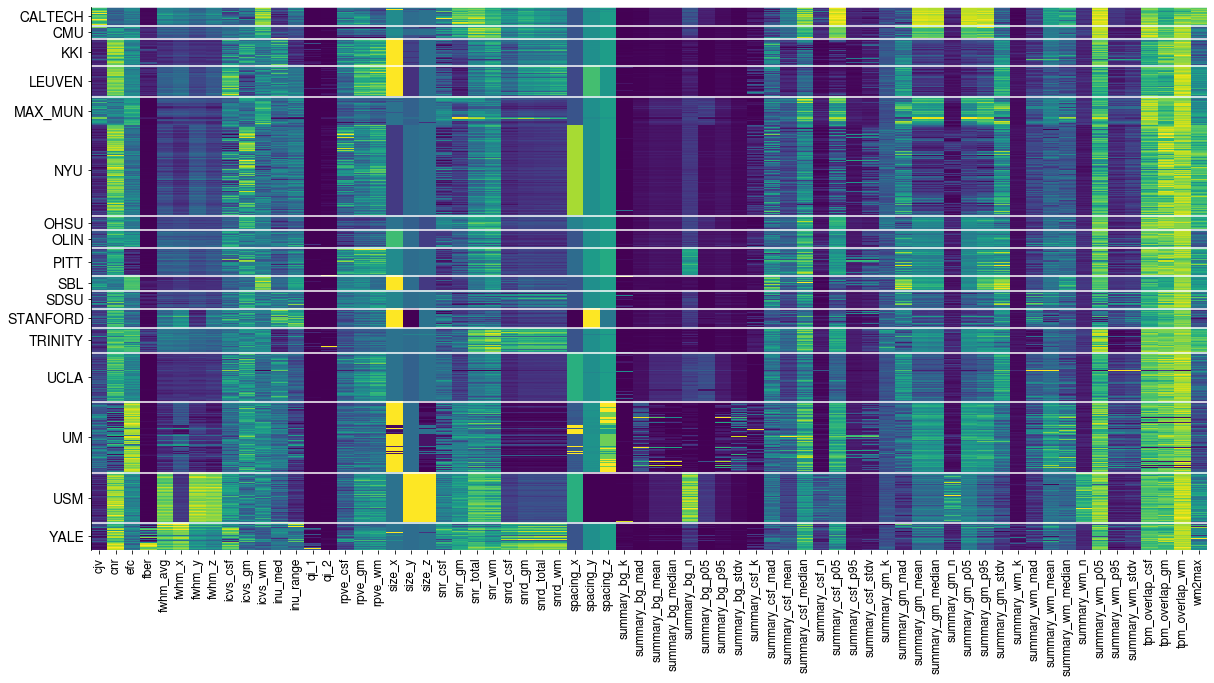

In [4]:
# 1. Let's import a module containing visualization tools for IQMs
from mriqc_learn.viz import metrics

# 2. Plot the dataset
fig1 = metrics.plot_batches(train_x)

The plot above is clearly blocky, very well aligned with the different acquisition sites that are comprehended.

## Homogenizing across sites

One first thought to make these IQMs more homogeneous would be to site-wise standardize them.
This means, for each site, calculate mean and standard deviation and apply them to convert IQMs to zero-mean, unit-variance distributions.
`mriqc-learn` has a filter (derived from, and compatible with `scikit-learn`) to do this:

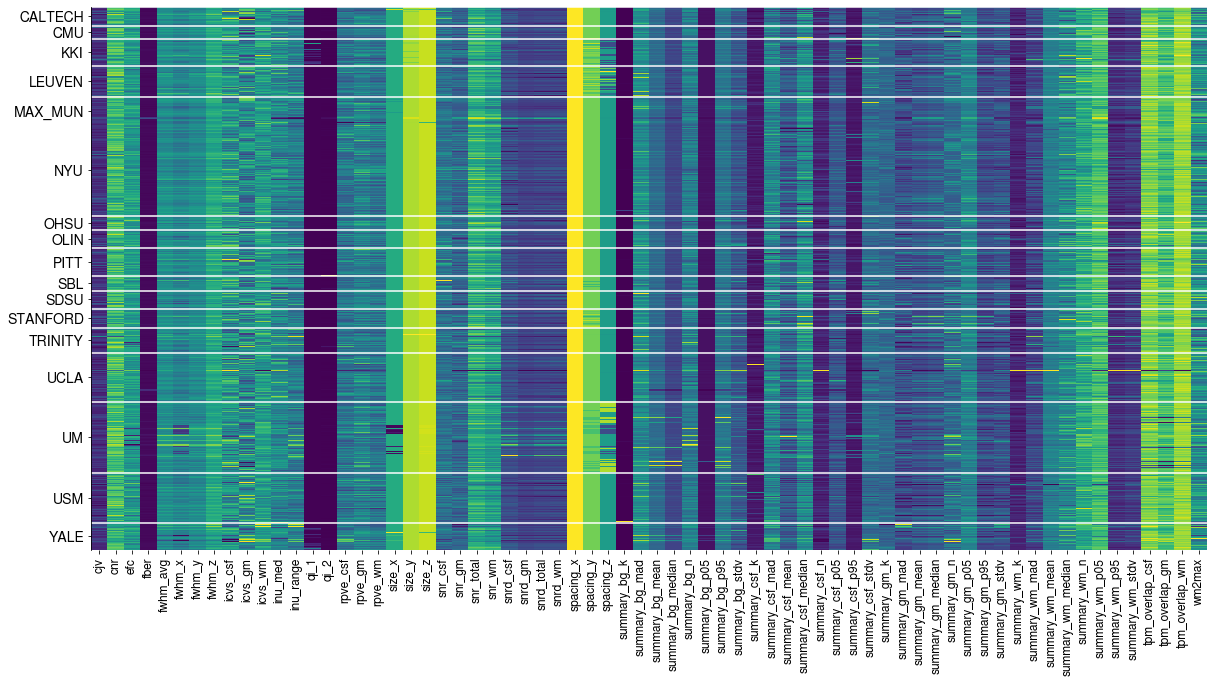

In [5]:
# Load the filter
from mriqc_learn.models.preprocess import SiteRobustScaler

# Plot data after standardization
standardized_x = SiteRobustScaler(unit_variance=True).fit_transform(train_x)
fig2 = metrics.plot_batches(standardized_x)

Now the plot is not so *blocky*.
The problem of using data that is not harmonized is that any model we train on those features heavily reliant on the site of acquisition will be better at picking up the site where the image was acquired rather than the quality.
This is so because perceived image quality by humans is very correlated with the site of acquisition.
In other words, our machine-learning model will operate like a human would do: *given that this site produces mostly poor images, I will assume all images coming from it are poor*.


## Manual ratings are very correlated with the acquisition site
Let's go further in exploring this effect, by now focusing our attention on the dataset targets (`train_y`).